# Load Libraries :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter, sobel
from scipy.ndimage import laplace

# 1 - Fundamental Level Sets (1980s-1990s)

## Introduction 
Instead of representing the active contour explicitly by a set of ordered point, We define the contour implicitely by the zero level set of a function phi(x,y), by evolving this function in time we can approch our desired contour.  
During evolution:
- *ϕ* is updated over time using a **partial differential equation (PDE)**.
- The idea is that *ϕ* deforms under some speed function so that the zero-level set (the contour) moves toward the object boundary in the image.

## Mathematical Formulation

The basic level set method represents a contour 𝐶 implicitly as the zero level set of a higher-dimensional function ϕ(x,y,t), where:
- (x,y) are spatial coordinates
- t is time/iteration
- The contour C is defined where ϕ(x,y,t) = 0

The contour evolution is governed by the level set equation:

$$\frac{\partial \phi}{\partial t} + F|\nabla \phi| = 0$$

Where:
- F is the speed function that controls the contour evolution
- ∇ϕ is the spatial gradient of ϕ

## Basic Algorithm Components

### 1. Level Set Function Initialization

Typically, the level set function is initialized as a signed distance function:
- ϕ(x,y,0) < 0 for points inside the initial contour
- ϕ(x,y,0) > 0 for points outside
- |ϕ(x,y,0)| represents the distance to the contour

A common initialization is:
$$\phi(x,y,0) = \pm d$$

Where d is the distance from (x,y) to the initial contour, and the sign depends on whether the point is inside (negative) or outside (positive).

### 2. Speed Function Design

For image segmentation, the speed function F typically depends on:
- Image gradient: to stop the contour at edges
- Curvature: to maintain smoothness

A basic speed function:
$$ F = g \cdot \kappa + \nabla g \cdot \nabla \phi $$

Where:
- g is an edge detector function (e.g., g = 1/(1+|∇I|²))
- I is the image
- κ is the curvature of the level set
- c (optional) is a constant (balloon force)

### 3. Level Set Evolution

At each iteration, update ϕ using:
$$\phi^{n+1} = \phi^n - \Delta t \cdot F|\nabla \phi^n|$$


#### Time Step Selection

For stability, the time step must satisfy the CFL condition:
$$\Delta t \leq \frac{\Delta x}{max(|F|)}$$

## Complete Algorithm

```
1. Initialize φ(x,y,0) as a signed distance function
2. Calculate the edge indicator function g(|∇I|)
3. For each iteration n:
   a. Calculate ∇φⁿ using finite differences
   b. Compute curvature κ
   c. Evaluate speed function F
   d. Update φⁿ⁺¹ = φⁿ - Δt·F|∇φⁿ|
   e. Periodically reinitialize φ to maintain signed distance property
4. Extract final contour from zero level set φ = 0
```



## Implementation :

In [ ]:
# Load image
img = cv2.imread("coin.png", cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

### 1. Initialize the LSF : φ(x,y,0)

In [ ]:
# 1. Initialize the LSF : φ(x,y,0)
def initialize_level_set_circle(shape, center=None, radius=None):
    """
    Initializes a level set function phi as a signed distance function to a circle.

    Parameters:
    - shape: tuple of ints, (height, width) of the domain
    - center: tuple (cx, cy) for the center of the circle; defaults to image center
    - radius: int, radius of the initial circle

    Returns:
    - phi: 2D numpy array of shape `shape`, representing the level set function
    """
    h, w = shape
    if center is None:
        center = (w // 2, h // 2)

    if radius is None:
        radius = (h // 2) - (h // 50)

    x = np.arange(0, w)
    y = np.arange(0, h)
    X, Y = np.meshgrid(x, y)

    # Signed distance to the circle: negative inside, zero on boundary, positive outside
    phi_init = np.sqrt((X - center[0])**2 + (Y - center[1])**2) - radius

    return phi_init

In [ ]:
# initialise the LSF as a signed distance function ( |∇φ| = 1 ) :

phi_init = initialize_level_set_circle(img.shape)

plt.figure()
plt.imshow(phi_init, cmap='coolwarm')
plt.colorbar()
plt.contour(phi_init, levels=[0], colors='r')  # zero level set
plt.title('Initial LSF')
plt.axis('off')
plt.show()

### 2. Calculate the edge indicator function g(|∇I|)
$$ g(|\nabla I|) = \frac{1}{1 + |\nabla I|^2} $$  
This function is **small near strong edges**, causing the evolution to slow down and stop there

In [ ]:
# 2. Calculate the edge indicator function g(|∇I|)
def compute_edge_indicator(img, sigma=1.0):
    """
    Compute the edge indicator function g for level set evolution.
    
    Parameters:
    - img: 2D array, input grayscale image
    - sigma: float, standard deviation for Gaussian smoothing
    
    Returns:
    - g: 2D array, edge indicator function
    """
    # Convert image to float if not already
    img = img.astype(float)
    
    # Normalize image to [0,1] if needed
    if np.max(img) > 1.0:
        img = img / 255.0
    
    # Step 1: Apply Gaussian smoothing to reduce noise
    img_smooth = gaussian_filter(img, sigma)
    
    # Step 2: Compute gradients using Sobel operators
    grad_x = sobel(img_smooth, axis=1)
    grad_y = sobel(img_smooth, axis=0)
    
    # Step 3: Compute gradient magnitude
    grad_mag = np.sqrt(grad_x**2 + grad_y**2 + 1e-10)  # Small epsilon to avoid division by zero
    
    # Step 4: Compute edge indicator function (standard formulation)
    g = 1.0 / (1.0 + grad_mag**2)
    
    # Apply a light smoothing to the edge indicator to reduce artifacts
    g = gaussian_filter(g, sigma=0.5)
    
    return g

In [ ]:
# compute the edge indicator function :

g = compute_edge_indicator(img)

plt.figure()
plt.imshow(g, cmap='gray')
plt.colorbar()
plt.title('edge indicator function g(|∇I|)')
plt.axis('off')
plt.show()

### 3. For each iteration n:
####    a. Calculate ∇φⁿ using finite differences  
- phi_x, phi_y for directional updates and geometric flow
- |∇φ| for evolving the zero level set in the normal direction

In [ ]:
# 3. For each iteration n:
#    a. Calculate ∇φⁿ using finite differences
def compute_phi_gradient(phi):
    """
    Compute the gradient of the level set function φ.

    Parameters:
    - phi: 2D array, the level set function

    Returns:
    - phi_x: derivative of φ in x direction (axis=1, columns)
    - phi_y: derivative of φ in y direction (axis=0, rows)
    - grad_phi_mag: gradient magnitude sqrt(φ_x^2 + φ_y^2)
    """
    grad_phi_y, grad_phi_x = np.gradient(phi)  # order: rows (y), columns (x)
    grad_phi_mag = np.sqrt(grad_phi_x**2 + grad_phi_y**2) + 1e-10  # small epsilon to avoid division by 0
    return grad_phi_x, grad_phi_y, grad_phi_mag

In [ ]:
# computing the gradients of phi :

grad_phi_x, grad_phi_y, grad_phi_mag = compute_phi_gradient(phi_init)

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 5))

# First subplot - gradient magnitude (unchanged)
plt.subplot(1, 2, 1)
im = plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
plt.colorbar(im)
plt.title('Gradient Magnitude of Phi')

# Second subplot - 3D surface plot of phi_init
ax = plt.subplot(1, 2, 2, projection='3d')
y, x = np.mgrid[:phi_init.shape[0], :phi_init.shape[1]]
surf = ax.plot_surface(x, y, phi_init, cmap='coolwarm', 
                      linewidth=0, antialiased=True, 
                      rcount=100, ccount=100)
ax.set_title('3D Surface Plot of Phi')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Phi Value')
ax.view_init(elev=30, azim=45)  # Set viewing angle

# Add a colorbar for the surface plot
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

####    b. Compute curvature κ  

$$ \kappa = \nabla \cdot \left( \frac{\nabla \phi}{|\nabla \phi|} \right) $$  
This curvature term is useful for:
- **Smoothing** the contour
- Regularizing its shape during evolution

In [ ]:
def compute_curvature(phi):
    """
    Compute the curvature of the level set function phi.
    
    The curvature is defined as the divergence of the normalized gradient:
    κ = div(∇φ/|∇φ|)
    
    Parameters:
    - phi: 2D array, level set function
    
    Returns:
    - curvature: 2D array, curvature of the level set
    """
    # Compute the gradient of phi
    phi_x, phi_y, grad_phi_mag = compute_phi_gradient(phi)
    
    # Compute the second derivatives
    # For x direction
    phi_xx = np.zeros_like(phi)
    phi_xx[:, 1:-1] = (phi[:, 2:] - 2*phi[:, 1:-1] + phi[:, :-2])  # Central difference for second derivative
    
    # For y direction
    phi_yy = np.zeros_like(phi)
    phi_yy[1:-1, :] = (phi[2:, :] - 2*phi[1:-1, :] + phi[:-2, :])  # Central difference for second derivative
    
    # Mixed derivative (xy)
    phi_xy = np.zeros_like(phi)
    phi_xy[1:-1, 1:-1] = (phi[2:, 2:] - phi[2:, :-2] - phi[:-2, 2:] + phi[:-2, :-2]) / 4.0
    
    # Small epsilon to avoid division by zero
    epsilon = 1e-10
    
    # Compute curvature using the formula:
    # κ = (φxx*φy² - 2*φxy*φx*φy + φyy*φx²) / (|∇φ|³)
    numerator = phi_xx * phi_y**2 - 2 * phi_xy * phi_x * phi_y + phi_yy * phi_x**2
    denominator = (grad_phi_mag**3 + epsilon)
    
    curvature = numerator / denominator
    
    # Limit the curvature values to avoid instabilities
    curvature = np.clip(curvature, -1.0, 1.0)
    
    return curvature

In [ ]:
# test the curvature function :

curvature = compute_curvature(phi_init)

plt.figure()
plt.imshow(curvature, cmap='gray')
plt.colorbar()
plt.title('curvature')
plt.axis('off')
plt.show()

#### c. Evaluate speed function F  

$$ F = g \cdot \kappa + \nabla g \cdot \nabla \phi $$
This form is equivalent to:
$$ F = g \cdot \kappa + g_x \cdot \phi_x + g_y \cdot \phi_y $$

In [ ]:
def compute_speed_function(phi, g, alpha=0.1, beta=1.2):
    """
    Compute the speed function for level set evolution.
    
    This implements a typical speed function that combines:
    1. Curvature-based regularization term
    2. Constant balloon force term
    3. External edge-based force term
    
    Parameters:
    - phi: 2D array, current level set function
    - g: 2D array, edge indicator function
    - alpha: float, weight of the balloon force term
    - beta: float, weight of the edge attraction term
    
    Returns:
    - speed: 2D array, speed function for level set evolution
    """
    # Compute curvature
    curvature = compute_curvature(phi)
    
    # Compute gradient of phi
    phi_x, phi_y, grad_phi_mag = compute_phi_gradient(phi)
    
    # Compute gradient of edge indicator function g
    g_x = np.zeros_like(g)
    g_y = np.zeros_like(g)
    
    # Central differences for interior points
    g_x[:, 1:-1] = (g[:, 2:] - g[:, :-2]) / 2.0
    g_y[1:-1, :] = (g[2:, :] - g[:-2, :]) / 2.0
    
    # Dot product of ∇g and ∇φ/|∇φ|
    epsilon = 1e-10  # Avoid division by zero
    nx = phi_x / (grad_phi_mag + epsilon)  # Normal vector x-component
    ny = phi_y / (grad_phi_mag + epsilon)  # Normal vector y-component
    edge_attraction = g_x * nx + g_y * ny
    
    # Compute speed function components:
    # 1. Curvature term: g * κ (regularization)
    # 2. Balloon force: g * α (expansion/contraction)
    # 3. Edge attraction: β * edge_attraction (pulls toward edges)
    speed = g * (curvature + alpha) + beta * edge_attraction
    
    return speed

In [ ]:
# compude the speed function used to update phi :

speed_function = compute_speed_function(phi_init, g, alpha=0.1, beta=1.2)

plt.figure()
plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Speed Function')
plt.axis('off')
plt.show()

#### d. Update φⁿ⁺¹ = φⁿ - Δt·F|∇φⁿ|
$$ \phi^{t+1} = \phi^t + \Delta t \cdot F |\nabla \phi| $$

#### e. Run iterative loop

In [ ]:
def level_set_contour_detection(image, nb_iter, center_initial=None, radius_initial=None, time_step=0.1, alpha=0.1, beta=1.2):
    """
    Perform level set evolution for contour detection.
    
    Parameters:
    - image: 2D array, grayscale image
    - nb_iter: int, number of iterations
    - center_initial: tuple, (x, y) coordinates of initial circle center
    - radius_initial: float, radius of initial circle
    - time_step: float, time step Δt
    - alpha: float, weight of the balloon force term
    - beta: float, weight of the edge attraction term
    
    Returns:
    - phi_n: 2D array, final level set function
    """

    iter_display = nb_iter//10

    # Initialize the LSF
    phi_init = initialize_level_set_circle(image.shape, center_initial, radius_initial)
    
    # Edge indicator function
    g = compute_edge_indicator(image)
    
    # Display inputs
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi_init, levels=[0], colors='r')
    plt.title('Input Image and Initial LSF Contour')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(g, cmap='gray')
    plt.title('Edge Indicator Function')
    plt.colorbar()
    plt.axis('off')
    
    plt.suptitle("Initial LSF and Input")
    plt.tight_layout()
    plt.show()
    
    # Initialize the loop
    phi_n = phi_init.copy()
    
    for i in range(nb_iter):
        # Compute ∇φ and |∇φ|
        phi_x, phi_y, grad_phi_mag = compute_phi_gradient(phi_n)
        
        # Compute speed function
        speed_function = compute_speed_function(phi_n, g, alpha=alpha, beta=beta)
        
        # Update φ
        phi_n = phi_n + time_step * speed_function * grad_phi_mag
        
        # Display every 10 iterations
        if ((i+1) % iter_display) == 0 :
            plt.figure(figsize=(20, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(image, cmap='gray')
            plt.contour(phi_n, levels=[0], colors='r')
            plt.title('iteration Contour')
            plt.axis('off')
            
            plt.subplot(1, 4, 2)
            plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Speed Function')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
            plt.colorbar()
            plt.title('grad_phi_mag')
            plt.axis('off')
            
            plt.subplot(1, 4, 4)
            plt.imshow(phi_n, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Level Set Function')
            plt.axis('off')
            
            plt.suptitle(f"Iteration {i+1}")
            plt.tight_layout()
            plt.show()
    
    # Final display
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi_n, levels=[0], colors='r')
    plt.title('iteration Contour')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Speed Function')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
    plt.colorbar()
    plt.title('grad_phi_mag')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(phi_n, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Level Set Function')
    plt.axis('off')
    
    plt.suptitle("Final Display")
    plt.tight_layout()
    plt.show()
    
    return phi_n

In [ ]:
# test of the fundamental level set algorithm time_step=0.1, alpha=0.1, beta=1.2 :

img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
phi_n = level_set_contour_detection(img, nb_iter=4000, time_step=0.1, alpha=0.1, beta=1.2)

## Conclusion:

- To prevent the evolution from diverging into artifacts across the level set function (LSF), the time step must be kept very small. However, this leads to significant computational cost.

- For the contour to evolve smoothly and accurately converge toward the edges, careful analysis and fine-tuning are required. In particular, selecting appropriate values for **α** (the weight of the balloon force that pushes the contour inward) and **β** (the weight of the edge attraction term that halts the evolution at boundaries) is highly dependent on the specific image.

- As iterations progress, the gradient magnitude |grad_phi| becomes increasingly steep, causing instabilities. This results in the formation of anomalies within the LSF, as well as irregular, unwanted contours near some inner edges.

##### For the algorithm to work the time_step must be small enough, as a result the level basic level sets algorithms with or without the reinitialisation are very computationally expensive.

In [ ]:
# test of the level set algorithm with time_step equal to 0.5 instead of 0.1 :

img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
phi_n = level_set_contour_detection(img, 4000, time_step=0.5, alpha=0.1, beta=1.2)

# 2 - Fundamental Level Set with Reinitialization (1990s)

## Issue :  

As the level set evolves over iterations, it gradually loses its signed distance property ( |∇φ| = 1 ) due to numerical errors and the nature of the evolution equation. The level set function can develop steep or flat regions where |∇φ| is far from 1. This causes:

- Regions where |∇φ| >> 1: very sttep gradient : Numerical instability and excessive contour movement
- Regions where |∇φ| << 1: Slow or stalled contour evolution
- Regions where |∇φ| = 1: regular signed distance : The absolute value of φ at any point equals the shortest distance to the contour.  
  
In level set methods, we ideally want the level set function φ to maintain a signed distance property, meaning **|∇φ| = 1** everywhere. This property is important because:

1. **Numerical stability**: When φ is a signed distance function, gradients are well-behaved and numerical calculations are more stable.

2. **Improved accuracy**: The contour evolution equations are derived assuming φ is a signed distance function.

3. **Consistent evolution speed**: Without maintaining the distance property, some regions might evolve faster than others, leading to uneven contour movement.

## Solution :

We periodically **reinitialize** phi to be a signed distance function again, **while preserving the zero level set**, It is like reshaping the level set function while preserving the zero level set (contour).

### Mathematical Formulation

Reinitialization solves the following PDE to steady state:

$$\frac{\partial \phi}{\partial \tau} = \text{sign}(\phi_0)(1-|\nabla \phi|)$$

Where:
- τ is an artificial time parameter (not the same as the evolution time t)
- φ₀ is the level set function before reinitialization
- sign(φ₀) ensures we preserve the sign (inside/outside) information

This equation acts as follows:
- When |∇φ| > 1: The term (1-|∇φ|) is negative, so φ decreases
- When |∇φ| < 1: The term (1-|∇φ|) is positive, so φ increases
- When |∇φ| = 1: The term (1-|∇φ|) is zero, so φ remains unchanged

The sign function ensures that:
- Inside regions (φ₀ < 0) stay negative
- Outside regions (φ₀ > 0) stay positive
- The zero level set (φ₀ = 0) remains fixed

In [ ]:
def reinitialize_phi(phi, iterations=10, dt=0.1):
    """
    Reinitialize phi to be a signed distance function.
    
    Parameters:
    - phi: 2D array, level set function to reinitialize
    - iterations: int, number of iterations for reinitialization
    - dt: float, time step for reinitialization
    
    Returns:
    - phi_reinit: 2D array, reinitialized level set function
    """
    # Store the original sign of phi
    phi_0 = phi.copy()
    sign_phi_0 = np.sign(phi_0)
    
    # Smoothed sign function to avoid discontinuities
    def smoothed_sign(x, epsilon=1.5):
        return x / np.sqrt(x**2 + epsilon**2)
    
    # Initialize phi_reinit
    phi_reinit = phi.copy()
    
    # Iterate to solve the reinitialization equation
    for _ in range(iterations):
        # Compute upwind gradients for reinitialization
        phi_x_p = np.zeros_like(phi_reinit)
        phi_x_m = np.zeros_like(phi_reinit)
        phi_y_p = np.zeros_like(phi_reinit)
        phi_y_m = np.zeros_like(phi_reinit)
        
        # Forward differences
        phi_x_p[:, :-1] = phi_reinit[:, 1:] - phi_reinit[:, :-1]
        phi_y_p[:-1, :] = phi_reinit[1:, :] - phi_reinit[:-1, :]
        
        # Backward differences
        phi_x_m[:, 1:] = phi_reinit[:, 1:] - phi_reinit[:, :-1]
        phi_y_m[1:, :] = phi_reinit[1:, :] - phi_reinit[:-1, :]
        
        # Choose upwind differences based on sign
        a = smoothed_sign(sign_phi_0)
        
        # For a > 0, use backward differences for "+" terms and forward for "-" terms
        phi_x_2 = np.maximum(np.maximum(phi_x_m, 0)**2, np.minimum(phi_x_p, 0)**2)
        phi_y_2 = np.maximum(np.maximum(phi_y_m, 0)**2, np.minimum(phi_y_p, 0)**2)
        
        # For a < 0, use forward differences for "+" terms and backward for "-" terms
        phi_x_2[a < 0] = np.maximum(np.minimum(phi_x_m[a < 0], 0)**2, np.maximum(phi_x_p[a < 0], 0)**2)
        phi_y_2[a < 0] = np.maximum(np.minimum(phi_y_m[a < 0], 0)**2, np.maximum(phi_y_p[a < 0], 0)**2)
        
        # Compute gradient magnitude
        grad_phi_mag = np.sqrt(phi_x_2 + phi_y_2)
        
        # Update phi_reinit
        phi_reinit = phi_reinit - dt * sign_phi_0 * (grad_phi_mag - 1.0)
    
    return phi_reinit

In [ ]:
def level_set_contour_detection_fundamental_reinitialization(image, nb_iter, center_initial=None, radius_initial=None, time_step=0.1, alpha=0.1, beta=1.2, reinit_every = None, initialisation_iter = None, initialisation_time_step=None):
    """
    Perform level set evolution for contour detection.
    
    Parameters:
    - image: 2D array, grayscale image
    - nb_iter: int, number of iterations
    - center_initial: tuple, (x, y) coordinates of initial circle center
    - radius_initial: float, radius of initial circle
    - time_step: float, time step Δt
    - alpha: float, weight of the balloon force term
    - beta: float, weight of the edge attraction term
    
    Returns:
    - phi_n: 2D array, final level set function
    """

    # inputs
    if reinit_every == None :
        reinit_every = nb_iter//5

    iter_display = nb_iter//10

    # Initialize the LSF
    phi_init = initialize_level_set_circle(image.shape, center_initial, radius_initial)
    
    # Edge indicator function
    g = compute_edge_indicator(image)
    
    # Display inputs
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi_init, levels=[0], colors='r')
    plt.title('Input Image and Initial LSF Contour')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(g, cmap='gray')
    plt.title('Edge Indicator Function')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Initialize the loop
    phi_n = phi_init.copy()
    
    for i in range(nb_iter):
        # Compute ∇φ and |∇φ|
        phi_x, phi_y, grad_phi_mag = compute_phi_gradient(phi_n)
        
        # Compute speed function
        speed_function = compute_speed_function(phi_n, g, alpha=alpha, beta=beta)
        
        # Update φ
        phi_n = phi_n + time_step * speed_function * grad_phi_mag
        
        # Display every 10 iterations
        if ((i+1) % iter_display) == 0 :
            plt.figure(figsize=(20, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(image, cmap='gray')
            plt.contour(phi_n, levels=[0], colors='r')
            plt.title('iteration Contour')
            plt.axis('off')
            
            plt.subplot(1, 4, 2)
            plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Speed Function')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
            plt.colorbar()
            plt.title('grad_phi_mag')
            plt.axis('off')
            
            plt.subplot(1, 4, 4)
            plt.imshow(phi_n, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Level Set Function')
            plt.axis('off')
            
            plt.suptitle(f"Iteration {i+1}")
            plt.tight_layout()
            plt.show()

        if (i+1) % reinit_every == 0:
            phi_n = reinitialize_phi(phi_n,  iterations=initialisation_iter, dt=initialisation_time_step)
            phi_x, phi_y, grad_phi_mag_display = compute_phi_gradient(phi_n)
            speed_function_display = compute_speed_function(phi_n, g, alpha=alpha, beta=beta)

            plt.figure(figsize=(20, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(image, cmap='gray')
            plt.contour(phi_n, levels=[0], colors='r')
            plt.title('iteration Contour')
            plt.axis('off')
            
            plt.subplot(1, 4, 2)
            plt.imshow(speed_function_display, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Speed Function')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(grad_phi_mag_display, cmap='coolwarm', vmin=0, vmax=2)
            plt.colorbar()
            plt.title('grad_phi_mag')
            plt.axis('off')
            
            plt.subplot(1, 4, 4)
            plt.imshow(phi_n, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Level Set Function')
            plt.axis('off')
            
            plt.suptitle(f"Reinitialization : Iteration {i+1}")
            plt.tight_layout()
            plt.show()
    
    # Final display
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi_n, levels=[0], colors='r')
    plt.title('iteration Contour')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Speed Function')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
    plt.colorbar()
    plt.title('grad_phi_mag')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(phi_n, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Level Set Function')
    plt.axis('off')
    
    plt.suptitle("Final Display")
    plt.tight_layout()
    plt.show()
    
    return phi_n

In [ ]:
# test of the level set with reinitialization algorithm time_step=0.1, alpha=0.1, beta=1.2, initialisation_iter=10, initialisation_time_step=0.1 :

img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
phi_n = level_set_contour_detection_fundamental_reinitialization(img, 4000, center_initial=None, radius_initial=None, time_step=0.1, alpha=0.1, beta=1.2, reinit_every = None, initialisation_iter=10, initialisation_time_step=0.1)

## Conclusion:

- The LSF transforms into an accurate and regular distance function, that also makes the irregular unwanted contours disapear.
- With the reinitialization we see that the irregular unwanted contours start to dissapear right after the reinitialization.
- This reinitialization process is computationally expensive and can cause the zero level set to shift unintentionally.

# 3 - Variational Level Set Methods (Early 2000s)

A major advancement came with variational formulations where level set evolution was derived by minimizing energy functionals:


$$ E(\phi) = \int\int [\text{internal energy terms} + \text{external energy terms}] , dxdy $$

Where:
- **E_internal**: Controls the regularity of the contour (smoothness, length)
- **E_external**: Drives the contour toward desired features (edges, regions)


The evolution equation became:
$$ ∂φ/∂t = -∂E/∂φ $$


### Common internal energy terms include:

1. **Length regularization**:
   
   $$ E_{\text{length}}(\phi) = \int\int \delta(\phi) |\nabla \phi| , dxdy $$
   
   The term Elength​(ϕ) approximates the length (or perimeter in 2D) of the contour defined by ϕ=0.  
   This penalizes the length of the contour, encouraging smoothness.

    **Dirac Delta Function δ(ϕ)** :
    The function δ(ϕ) is a Dirac delta function that is non-zero only where ϕ=0, i.e., on the contour. It acts like a "selector" that focuses the integral on the zero level set. In practice, δ(ϕ) is approximated by a smooth function (e.g., a Gaussian-like function) to handle numerical computations.

2. **Area constraint**:
   
   $$ E_{\text{area}}(\phi) = \int\int H(-\phi) , dxdy $$
   
   This term controls the area enclosed by the contour, preventing collapse or excessive expansion.

   **Heaviside Function H(−ϕ)** : corresponds to 1 inside of the contour and in the contour, and 0 outside of it.

### External Energy Terms

These are application-specific and draw the contour toward features of interest:

1. **Edge-based terms**:
   
   $$ E_{\text{edge}}(\phi) = \int\int g * \delta(\phi) |\nabla \phi| , dxdy $$
   
   Where g is the edge indicator function that approaches zero at edges.

   The term E_edge​ is a weighted length of the contour, where the weighting is provided by the edge indicator **g**. Since **g** is small at edges, minimizing E_edge​ encourages the contour to align with image edges, where the energy contribution is low. Mathematically:  

    - The δ(ϕ) restricts the integral to the contour (ϕ=0).  
    - The term  ∣∇ϕ∣dxdy contributes to the arc length along the contour.  
    - The factor **g** weights the arc length, making it “cheaper” (lower energy) for the contour to lie on edges where g≈0.  

2. **Region-based terms**:
   
   $$ E_{\text{region}}(\phi) = \int\int (I - c_1)^2 H(-\phi) , dx + \int (I - c_2)^2 (1 - H(-\phi)) , dxdy $$

   This models the image as consisting of regions with different statistical properties (like the Chan-Vese model).

## The Algorithm for Contour Evolution

### Step 1: Formulate the Energy Functional
Define E(φ) with appropriate terms for your application.

### Step 2: Derive the Evolution Equation
Using calculus of variations, we compute the Euler-Lagrange equation:

$$∂φ/∂t = -∂E/∂φ$$


This gradient descent approach ensures φ evolves in the direction that decreases E most rapidly.

### Step 3: Discretize the Evolution Equation
Convert the continuous equation to a discrete update scheme:

$$ \phi^{n+1} = \phi^n + \Delta t \cdot \left(-\frac{\partial E}{\partial \phi}\right) $$


### Step 4: Numerically Implement the Update Scheme

For example, the gradient descent for a simple model might look like:

$$ \phi^{n+1} = \phi^n + \Delta t \cdot \left[ \lambda \delta(\phi) \text{div}\left(\frac{\nabla \phi}{|\nabla \phi|}\right) + \nu \delta(\phi) + \mu \delta(\phi) (I - c_1)^2 - \mu \delta(\phi) (I - c_2)^2 \right] $$


Where:
- First term: Curvature regularization
- Second term: Balloon force
- Third & fourth terms: Region forces

### Step 5: Maintain Numerical Stability
Implement upwind schemes, enforce Courant-Friedrichs-Lewy (CFL) condition, and use regularization.

### Step 6: Handle the Signed Distance Property
In traditional variational methods, this is done through periodic reinitialization.


This provided a more principled approach but still required reinitialization.


# 4 - Development of DRLSE (Li et al., 2010)

Li and colleagues recognized that reinitialization was:
1. Computationally expensive
2. Theoretically artificial (not derived from the original variational problem)
3. Potentially disruptive to the evolving contour

Their key insight was to incorporate distance regularization directly into the energy functional:

$$E(\phi) = \mu R_p(\phi) + \lambda L_g(\phi) + \alpha A_g(\phi)$$

Where:
- $R_p(\phi)$ is the distance regularization term
- $L_g(\phi)$ is the length term
- $A_g(\phi)$ is the area term

## The Distance Regularization Term

The critical innovation was the distance regularization term:

$$R_p(\phi) = \int\int p(|\nabla\phi|) \, dxdy$$

With potential function $p$ designed so that:
- $|\nabla\phi| = 1$ is a minimum of $p(s)$ -> The gradient flow of $R_p$ automatically maintains the signed distance property

## Potential Function Design

Li et al. proposed two potential functions:

1. **Single-well**: $p_1(s) = \frac{1}{2}(s-1)^2$
   - one minimum at $|\nabla\phi| = 1$ -> The gradient flow of $R_p$ automatically maintains a complete signed distance property
   - Simpler but only works well for region-based models
   - the derived level set evolution for energy minimization has an undesirable side effect on the LSF in some circumstances
   
2. **Double-well**: $p_2(s) = \begin{cases}
     \frac{\sin(2\pi s)}{2\pi} & \text{if } s \leq 1 \\
     (s-1) & \text{if } s > 1
   \end{cases}$
   - two minimums at $|\nabla\phi| = 1$ and $|\nabla\phi| = 0$ -> aimed to maintain the signed distance property only in a vicinity of the zero level set, while keeping the LSF as a constant at locations far away from the zero level set.  
   - Works for both edge-based and region-based models 
     
   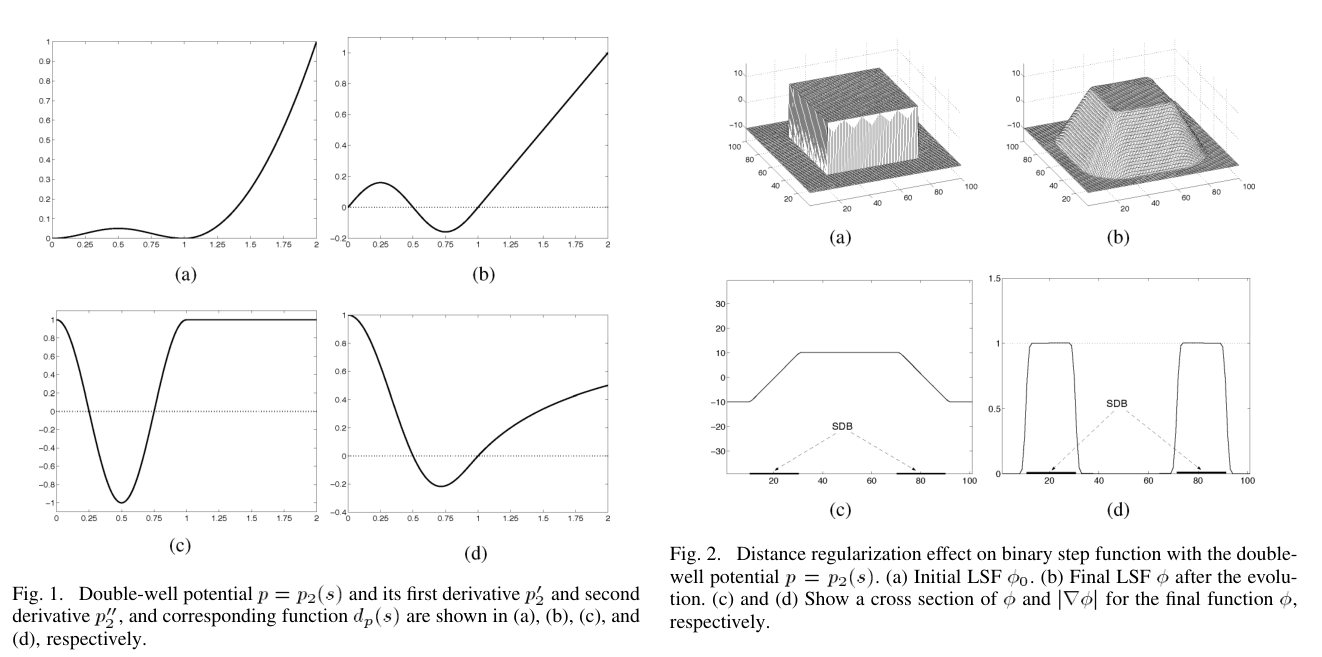  
     
## Implementation
### Gradient Flow for Energy Minimization :  
   To minimise E we use the gradient decsent on Euler-Lagrange equation :
   $$ ∂φ/∂t = -∂E/∂φ $$
   Where the regularisation term translates to $$ ∂Rp/∂φ $$
   The Gâteaux derivative of the functional Rp(φ) is 
   $$ -div(d_p(|\nabla\phi|)\nabla\phi) $$
   Where 
   $$ d_p(s) = \frac{p'(s)}{s} $$
   It can be rewriten :
   $$\text{div}(d_p(|\nabla \phi|) \nabla \phi) = \text{div}((d_p(|\nabla \phi|) - 1) \nabla \phi) + \text{div}(\nabla \phi)$$

### Numerisation :
   - The spatial derivatives $ ∂φ/∂x $ and $ ∂φ/∂y $ are approximated by the central difference ($ \Delta x = \Delta y = 1 $)

### The Complete Update Equation

The level set function update equation (phi_n+1 = phi_n + ...) in implementation becomes:

$$\phi^{n+1} = \phi^n + \Delta t \left[ \mu \cdot \text{div}(d_p(|\nabla \phi^n|) \nabla \phi^n) + \lambda \delta_\epsilon(\phi^n) \text{div}\left(g \frac{\nabla \phi^n}{|\nabla \phi^n|}\right) + \alpha g \delta_\epsilon(\phi^n) \right]$$

Where:
- $\phi^n$ is the level set function at iteration n
- $\Delta t$ is the time step
- $\mu$, $\lambda$, and $\alpha$ are weighting parameters for the respective terms
- $d_p(s) = \frac{p'(s)}{s}$ is the derivative of the potential function divided by s
- $\delta_\epsilon$ is the regularized Dirac delta function
- $g$ is an edge indicator function (typically $g = \frac{1}{1 + |\nabla G_\sigma * I|^2}$)

## Breaking Down the Components

1. **Distance Regularization Term**: $\mu \cdot \text{div}(d_p(|\nabla \phi^n|) \nabla \phi^n)$
   - Maintains the signed distance property
   - $d_p$ behavior depends on the chosen potential function (single-well or double-well)

2. **Length Term**: $\lambda \delta_\epsilon(\phi^n) \text{div}\left(g \frac{\nabla \phi^n}{|\nabla \phi^n|}\right)$
   - Smooths the zero level contour
   - Only affects regions near the zero level set due to $\delta_\epsilon$

3. **Area Term**: $\alpha g \delta_\epsilon(\phi^n)$
   - Controls the evolution speed
   - Forces the contour to expand or shrink depending on the sign of $\alpha$

In numerical implementation, these differential operators are approximated using finite differences, with special care given to the computation of $d_p(|\nabla \phi|)$ to ensure stability.


In [ ]:
# Load image
img = cv2.imread("coin.png", cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

In [ ]:
# Init phi

def initialize_level_set_binary_square(img_shape, c0=1, square_size_ratio=0.8):
    """
    Initialize a level set function as a binary square.
    
    Parameters:
    -----------
    img_shape : tuple
        Shape of the image (height, width)
    square_size_ratio : float, optional
        Size of the square as a ratio of the image dimensions (default: 0.4)
        
    Returns:
    --------
    phi_init : ndarray
        Binary level set function with 1 inside the square and 0 outside
    """
    phi_init = np.zeros(img_shape)
    phi_init[:,:] = c0
    
    # Calculate square dimensions
    h, w = img_shape
    center_y, center_x = h // 2, w // 2
    square_size_y = int(h * square_size_ratio / 2)
    square_size_x = int(w * square_size_ratio / 2)
    
    # Set square region to 1
    y_min = max(0, center_y - square_size_y)
    y_max = min(h, center_y + square_size_y)
    x_min = max(0, center_x - square_size_x)
    x_max = min(w, center_x + square_size_x)
    
    phi_init[y_min:y_max, x_min:x_max] = -c0
    
    return phi_init

In [ ]:
# initialise the LSF as a signed distance function ( |∇φ| = 1 ) :

phi_init = initialize_level_set_binary_square(img.shape, square_size_ratio=0.5)

plt.figure()
plt.imshow(phi_init, cmap='coolwarm')
plt.colorbar()
plt.contour(phi_init, levels=[0], colors='r')  # zero level set
plt.title('Initial LSF')
plt.axis('off')
plt.show()

In [ ]:
# compute the edge indicator function :

g = compute_edge_indicator(img)

plt.figure()
plt.imshow(g, cmap='gray')
plt.colorbar()
plt.title('edge indicator function g(|∇I|)')
plt.axis('off')
plt.show()

## Distance regularisation term :

$$R_p(\phi) = \int_{\Omega} p(|\nabla \phi|) \, dx$$

   - Maintains the signed distance property
   - $d_p$ behavior depends on the chosen potential function (single-well or double-well)

Taking the Gâteaux derivative (functional derivative) of this term, we get:
$$\frac{\partial R_p}{\partial \phi} = -\text{div}(d_p(|\nabla \phi|) \nabla \phi)$$

Where $d_p(s) = \frac{p'(s)}{s}$.

Let's expand this term:

$$\text{div}(d_p(|\nabla \phi|) \nabla \phi) = \nabla \cdot (d_p(|\nabla \phi|) \nabla \phi)$$

To understand where the Laplacian comes from, we can rewrite this as:

$$\text{div}(d_p(|\nabla \phi|) \nabla \phi) = \text{div}((d_p(|\nabla \phi|) - 1 + 1) \nabla \phi)$$
$$= \text{div}((d_p(|\nabla \phi|) - 1) \nabla \phi) + \text{div}(\nabla \phi)$$

The second term $\text{div}(\nabla \phi)$ is precisely the Laplacian $\nabla^2 \phi$.


In [ ]:
def div(nx: np.ndarray, ny: np.ndarray) -> np.ndarray:
    [_, nxx] = np.gradient(nx)
    [nyy, _] = np.gradient(ny)
    return nxx + nyy

In [ ]:
def dist_reg_p2(phi):
    """
        compute the distance regularization term with the double-well potential p2 in equation (16)
    """
    # Calculate the gradient of phi in both directions
    [phi_y, phi_x] = np.gradient(phi)
    
    # Calculate the magnitude of the gradient
    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
    
    # Create masks for different regions based on magnitude
    a = (s >= 0) & (s <= 1)  # Where s is between 0 and 1
    b = (s > 1)              # Where s is greater than 1
    
    # Calculate the derivative of the double-well potential
    # p2'(s) = sin(2πs)/(2π) for s≤1, and p2'(s) = 1 for s>1
    ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)
    
    # Calculate d_p(s) = p'(s)/s, handling the special case where s=0
    dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))
    
    # Return the divergence term + Laplacian term
    return div(dps * phi_x - phi_x, dps * phi_y - phi_y) + laplace(phi, mode='nearest'), dps, ps

In [ ]:
# Create a grid and initialize phi as a binary square

reg_term, dps, ps = dist_reg_p2(phi_init)

# Visualization
plt.figure(figsize=(12, 5))

# Plot the d_p(s) term to visualize regularization effect
plt.subplot(1,2,1)
plt.imshow(dps, cmap='Blues')
plt.title('d_p(s) = p\'(s)/s Term')
plt.colorbar()

# Plot the reg_term term to visualize regularization effect
plt.subplot(1,2,2)
plt.imshow(reg_term, cmap='Blues')
plt.title('reg_term = div(dps*grad_phi) Term')
plt.colorbar()

plt.tight_layout()
plt.show()

## Length Term (contour smoother) : 

### Role
The length term ($\lambda \cdot \delta(\phi) \cdot \text{div}\left(\frac{\nabla \phi}{|\nabla \phi|}\right)$) minimizes the contour length by:

1. **Smoothing Effect**: It acts as a regularization that removes noise and small oscillations in the contour
2. **Curvature Minimization**: It pushes parts of the contour with high curvature toward a straighter configuration
3. **Geometric Constraint**: It prevents the contour from developing complicated shapes unless justified by other energy terms


### Mathematical Form

The classic length term is defined as:

$$L_g(\phi) = \int_\Omega g \delta(\phi) |\nabla \phi| \, dx$$

Where:
- $g$ is an edge indicator function (typically $g = \frac{1}{1 + |\nabla I|^2}$)
- $\delta(\phi)$ is the Dirac delta function
- $|\nabla \phi|$ is the magnitude of the gradient of the level set function

When computing the gradient descent flow, we get:

$$\frac{\partial \phi}{\partial t} = \delta(\phi) \cdot \text{div}\left(g \frac{\nabla \phi}{|\nabla \phi|}\right)$$

### Implementation

The code follows these mathematical steps:

1. **Compute the gradient**: Calculate $\nabla \phi = (\phi_x, \phi_y)$

2. **Normalize the gradient**: Calculate $\mathbf{n} = \frac{\nabla \phi}{|\nabla \phi|}$, which gives the unit normal vector to the level set

3. **Weight by the edge indicator**: Calculate $g \cdot \mathbf{n}$

4. **Compute the divergence**: Calculate $\text{div}(g \cdot \mathbf{n})$

5. **Apply the Dirac delta**: Multiply by $\delta(\phi)$ to limit the effect to the zero level set vicinity

This directly implements the formula:
$$\delta(\phi) \cdot \text{div}\left(g \frac{\nabla \phi}{|\nabla \phi|}\right)$$

In [ ]:
def dirac(x: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    f = (1 / 2 / sigma) * (1 + np.cos(np.pi * x / sigma))
    b = (x <= sigma) & (x >= -sigma)
    return f * b

In [ ]:
def compute_edge_term(phi, g, epsilon):
    """
    Computes the edge-based term for the DRLSE model, combining both length and area terms.
    
    This function calculates the force exerted by image edges on the evolving level set function
    through two components:
    1. The geodesic length term (weighted by g): dirac_phi * g * curvature
    2. The advection term: dirac_phi * (vx * n_x + vy * n_y)
    
    Parameters:
    -----------
    phi : ndarray
        The level set function (LSF)
    g : ndarray
        The edge indicator function with low values at edges and high values in homogeneous regions
    epsilon : float
        Width parameter for the Dirac delta function approximation
        
    Returns:
    --------
    edge_term : ndarray
        Combined force from edge-based terms that drives the LSF toward object boundaries
    """
    # Calculate gradient of edge indicator function
    vy, vx = np.gradient(g)
    
    # Calculate gradient of level set function
    phi_y, phi_x = np.gradient(phi)
    
    # Compute magnitude of LSF gradient (used for normalization)
    gradient_magnitude = np.sqrt(np.square(phi_x) + np.square(phi_y))
    
    # Avoid division by zero with small delta
    delta = 1e-10
    
    # Compute normal vectors (unit vectors pointing in gradient direction)
    n_x = phi_x / (gradient_magnitude + delta)
    n_y = phi_y / (gradient_magnitude + delta)
    
    # Calculate curvature (divergence of normal vectors)
    curvature = div(n_x, n_y)
    
    # Compute Dirac delta approximation of LSF
    dirac_phi = dirac(phi, epsilon)
    
    # Compute edge term components:
    # 1. Advection term: pulls LSF toward edges
    advection_term = dirac_phi * (vx * n_x + vy * n_y)
    
    # 2. Curvature term: smooths the contour
    curvature_term = dirac_phi * g * curvature
    
    # Combine both forces
    edge_term = advection_term + curvature_term
    
    return edge_term

"""
def compute_length_term(phi, g, sigma):
    # Calculate gradient of phi
    phi_y, phi_x = np.gradient(phi)
    
    # Calculate gradient magnitude (add small epsilon to avoid division by zero)
    grad_norm = np.sqrt(phi_x**2 + phi_y**2 + 1e-10)
    
    # Normalize gradient vectors
    nx = phi_x / grad_norm
    ny = phi_y / grad_norm
    
    # Weight by edge indicator function
    weighted_nx = g * nx
    weighted_ny = g * ny
    
    # Calculate divergence of weighted normalized gradient
    div_y, div_x = np.gradient(weighted_nx)
    div_y2, div_x2 = np.gradient(weighted_ny)
    div = div_x + div_y2
    
    # Multiply by regularized Dirac delta
    dirac_phi = dirac(phi, sigma)
    length_term = dirac_phi * div
    
    return length_term
"""

In [ ]:
length_term = compute_edge_term(phi_init, g, epsilon=1.5)

# Visualization
plt.figure(figsize=(12, 5))

# Plot the LSF
plt.subplot(1,2,1)
plt.imshow(phi_init, cmap='coolwarm')
plt.colorbar()
plt.contour(phi_init, levels=[0], colors='r')  # zero level set
plt.title('Initial LSF')
plt.axis('off')

# Plot the length_term
plt.subplot(1,2,2)
plt.imshow(length_term, cmap='Blues')
plt.title('length_term')
plt.colorbar()

plt.tight_layout()
plt.show()


## Area Term (baloon force) : 

### Role 

The area term ($\mu \cdot \delta(\phi)$) provides:

1. **Directional Bias**: A consistent force to either expand or contract the contour
2. **Global Control**: Affects the entire active contour equally, regardless of local image features
3. **Dynamic Balance**: Counteracts other forces when needed to achieve proper segmentation

Intuitively, the area term in DRLSE controls the expansion or contraction behavior of the evolving contour:

- When the area term coefficient is positive, it creates a "shrinking force" that makes the contour contract inward
- When the area term coefficient is negative, it creates an "expanding force" that pushes the contour outward

## Mathematical Explanation

In the DRLSE framework, the area term is represented as:

$$E_{area}(\phi) = \alpha \cdot A(\phi) = \alpha \int_{\Omega} H(\phi(x)) dx$$

Where:
- $\phi$ is the level set function
- $H$ is the Heaviside function
- $\alpha$ is the coefficient controlling the weight of the area term
- $\Omega$ is the image domain
- $A(\phi)$ represents the area enclosed by the zero-level contour

The corresponding gradient flow (evolution equation) contribution from this term is:

$$\frac{\partial \phi}{\partial t} = ... + \alpha \cdot \delta(\phi)$$

Where $\delta(\phi)$ is the Dirac delta function.

The Heaviside function $H(\phi)$ is defined as:
- $H(\phi) = 1$ if $\phi \geq 0$ (inside the contour)
- $H(\phi) = 0$ if $\phi < 0$ (outside the contour)

The area term essentially measures the area inside the zero level set. When we take the gradient descent of this energy term, it produces a force along the normal direction of the contour with magnitude $\alpha$. The sign of $\alpha$ determines whether the contour expands or shrinks.

In [ ]:
def compute_area_term(phi, g) :
    area_term = phi * g  # balloon/pressure force
    return area_term

In [ ]:
area_term = compute_area_term(phi_init, g) 

# Visualization
plt.figure(figsize=(12, 5))

# Plot the LSF
plt.subplot(1,2,1)
plt.imshow(phi_init, cmap='coolwarm')
plt.colorbar()
plt.contour(phi_init, levels=[0], colors='r')  # zero level set
plt.title('Initial LSF')
plt.axis('off')

# Plot the area_term
plt.subplot(1,2,2)
plt.imshow(area_term, cmap='Blues')
plt.title('area_term')
plt.colorbar()

plt.tight_layout()
plt.show()

## Full Edge-Based DRLSE Implementation

The Distance Regularized Level Set Evolution (DRLSE) model with edge-based energy functionals can be expressed as a sum of three key energy terms:

$$E(\phi) = \mu R_p(\phi) + \lambda L_g(\phi) + \alpha A_g(\phi)$$

Where:
- $\phi$ is the level set function (LSF)
- $R_p(\phi)$ is the distance regularization term that maintains the signed distance property
- $L_g(\phi)$ is the length term weighted by an edge indicator function $g$
- $A_g(\phi)$ is the area term also weighted by the edge indicator function $g$
- $\mu$, $\lambda$, and $\alpha$ are coefficients controlling the relative importance of each term

According to the calculus of variations, the LSF evolves in the direction of the negative gradient flow of the energy functional:

$$ \frac{\partial\phi}{\partial t} = -\frac{\partial E}{\partial\phi} $$

Expanding this evolution equation:

$$ \frac{\partial\phi}{\partial t} = -\mu \frac{\partial R_p}{\partial\phi} - \lambda \frac{\partial L_g}{\partial\phi} - \alpha \frac{\partial A_g}{\partial\phi} $$

In numerical implementation, the level set function is updated iteratively using a forward Euler time discretization scheme:

$$\phi_{t+1} = \phi_t + \Delta t \cdot \left(\mu \cdot \text{reg\_term} + \lambda \cdot \text{length\_term} + \alpha \cdot \text{area\_term}\right)$$

Where:
- $\phi_{t+1}$ is the updated LSF at time step $t+1$
- $\phi_t$ is the current LSF at time step $t$
- $\Delta t$ is the time step size
- reg_term represents the distance regularization force $-\frac{\partial R_p}{\partial\phi}$
- length_term represents the length minimization force $-\frac{\partial L_g}{\partial\phi}$
- area_term represents the area expansion/contraction force $-\frac{\partial A_g}{\partial\phi}$

This iterative process continues until convergence, with the zero level set of $\phi$ representing the final segmentation contour.



In [ ]:
def neumann_bound_cond(f):
    """
        Make a function satisfy Neumann boundary condition
    """
    g = f.copy()

    g[np.ix_([0, -1], [0, -1])] = g[np.ix_([2, -3], [2, -3])]
    g[np.ix_([0, -1]), 1:-1] = g[np.ix_([2, -3]), 1:-1]
    g[1:-1, np.ix_([0, -1])] = g[1:-1, np.ix_([2, -3])]
    return g

In [ ]:
def level_set_contour_detection_fundamental_reinitialization(image, nb_iter, lmda, mu, alfa, epsilon, time_step, phi_init_square_size_ratio=0.9): 

    iter_display = nb_iter//10

    # Initialize the LSF
    phi_init = initialize_level_set_binary_square(image.shape, square_size_ratio=phi_init_square_size_ratio)

    # Edge indicator function
    g = compute_edge_indicator(image)


    # Display inputs
    reg_term, dps, ps = dist_reg_p2(phi_init)

    length_term = compute_edge_term(phi_init, g, epsilon)

    area_term = compute_area_term(phi_init, g) 

    speed_function = lmda*reg_term + mu*length_term + alfa*area_term
    
    plt.figure(figsize=(20, 4))

    plt.subplot(2, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi_init, levels=[0], colors='r')
    plt.title('iteration Contour')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Speed Function (all terms)')
    plt.axis('off')

    plt.subplot(2, 4, 3)
    phi_x, phi_y, grad_phi_mag = compute_phi_gradient(phi_init)
    plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
    plt.colorbar()
    plt.title('grad_phi_mag')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(phi_init, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Level Set Function')
    plt.axis('off')

    plt.subplot(2, 4, 5)
    plt.imshow(lmda*reg_term, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('lmda*reg_term')
    plt.axis('off')

    plt.subplot(2, 4, 6)
    plt.imshow(mu*length_term, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('mu*length_term')
    plt.axis('off')

    plt.subplot(2, 4, 7)
    plt.imshow(alfa*area_term, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('alfa*area_term')
    plt.axis('off')
    
    plt.suptitle(f"Initial state")
    plt.tight_layout()
    plt.show()


    # Initialize the loop
    phi_n = phi_init.copy()

    for i in range(nb_iter):
        phi_n = neumann_bound_cond(phi_n)
        
        reg_term, dps, ps = dist_reg_p2(phi_n)

        length_term = compute_edge_term(phi_n, g, epsilon)

        area_term = compute_area_term(phi_n, g) 

        speed_function = lmda*reg_term + mu*length_term + alfa*area_term

        # Update φ
        phi_n = phi_n + time_step * (lmda*reg_term + mu*length_term + alfa*area_term)
        
        # Display every 10 iterations
        if ((i+1) % iter_display) == 0 :
            plt.figure(figsize=(20, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(image, cmap='gray')
            plt.contour(phi_n, levels=[0], colors='r')
            plt.title('iteration Contour')
            plt.axis('off')
            
            plt.subplot(1, 4, 2)
            plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Speed Function (all terms)')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            phi_x, phi_y, grad_phi_mag = compute_phi_gradient(phi_n)
            plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
            plt.colorbar()
            plt.title('grad_phi_mag')
            plt.axis('off')
            
            plt.subplot(1, 4, 4)
            plt.imshow(phi_n, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Level Set Function')
            plt.axis('off')
            
            plt.suptitle(f"Iteration {i+1}")
            plt.tight_layout()
            plt.show()

    plt.figure(figsize=(20, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi_n, levels=[0], colors='r')
    plt.title('iteration Contour')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(speed_function, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Speed Function (all terms)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    phi_x, phi_y, grad_phi_mag = compute_phi_gradient(phi_n)
    plt.imshow(grad_phi_mag, cmap='coolwarm', vmin=0, vmax=2)
    plt.colorbar()
    plt.title('grad_phi_mag')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(phi_n, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Level Set Function')
    plt.axis('off')
    
    plt.suptitle(f"Last Iteration")
    plt.tight_layout()
    plt.show()
    return phi_n

In [ ]:
# test of the DRLSE level set algorithm : nb_iter=1000, time_step=0.02, lmda=10, alfa=0.1, , sigma=1.5

img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
phi_n = level_set_contour_detection_fundamental_reinitialization(img, nb_iter=1000, lmda=10, mu=2, alfa=0.6, epsilon=1.5, time_step=0.02, phi_init_square_size_ratio=0.7)